C:\Users\yh1024\Box\LAB\Lab Folder\EXPERIMENTS\CONFOCAL EXPERIMENTS\lipid peroxidation

Import Libraries

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, binary_dilation, disk
import czifile
import skimage.io as io
from skimage import exposure
from cellpose import models
from skimage.filters import unsharp_mask
from skimage.segmentation import find_boundaries

model = models.Cellpose(model_type='cyto3')
# model = models.Cellpose(model_type='nuclei')

In [8]:
MIN_INCLUSION_SIZE = 10
MAX_INCLUSION_SIZE = 10000
COLOR_SCHEME = 'hot'
RADIUS = 15

Define Sub Functions

In [9]:
def show_image(image,cmap=COLOR_SCHEME):
    io.imshow(image, cmap=cmap)
    plt.show()

def preprocess_green_channel(green_channel):
    """Preprocess the green channel for cell segmentation and inclusion quantification."""
    confocal_img = gaussian(green_channel, sigma=2)
    # increase image contrast
    
    # confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())
    
    return confocal_img

def preprocess_dapi_channel(dapi_channel):
    """Preprocess the DAPI channel for nuclei quantification."""
    blurred_dapi = gaussian(dapi_channel, sigma=2)
    threshold_value = threshold_otsu(blurred_dapi)
    binary_image = blurred_dapi > threshold_value
    # show_image(binary_image)
    cleaned_image = remove_small_objects(binary_image, min_size=400)
    merged_image = binary_dilation(cleaned_image, footprint=disk(5))
    labeled_image = label(merged_image)
    return labeled_image

def count_nuclei(labeled_image):
    """Count the number of nuclei in the labeled image."""
    return len(np.unique(labeled_image)) - 1


def increase_contrast(image):
    """Increase the contrast of the image."""
    p2, p98 = np.percentile(image, (2, 98))
    return exposure.rescale_intensity(image, in_range=(p2, p98))

def segment_cells(green_channel):
    """Segment cells in the green channel."""
    mean_intensity = np.mean(green_channel[green_channel > 0.2])
    # print("Mean Intensity: ", mean_intensity)
    green_channel_remove_inclusions = np.where(green_channel < 0.6, green_channel, mean_intensity) # dim down inclusions
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=5) # blur
    
    # normalize
    green_channel_remove_inclusions = (green_channel_remove_inclusions - np.min(green_channel_remove_inclusions)) / ((np.max(green_channel_remove_inclusions) - np.min(green_channel_remove_inclusions)))
    # show_image(green_channel_remove_inclusions)

    # Detect cells in the green channel
    # keep increasing diameter until cells are detected
    diameter = 150

    while diameter < 500:

        masks, flows, styles, diams = model.eval(green_channel_remove_inclusions, diameter=diameter, channels=[0, 0])
        labeled_cells = label(masks)
        # if there are more than 0 cells
        if np.max(labeled_cells) > 0:
            return labeled_cells
        diameter += 25
    # no cells found, throw an error
    return None

def extract_inclusions(green_channel,mask,display_graph=False):
    applied_mask_blurred = gaussian(green_channel, sigma=1) * mask
    applied_mask_eliminate_background = applied_mask_blurred[applied_mask_blurred > 0] # filter out 0
    
    # normalize 
    applied_mask_eliminate_background = (applied_mask_eliminate_background - np.min(applied_mask_eliminate_background)) / ((np.max(applied_mask_eliminate_background) - np.min(applied_mask_eliminate_background)))

    # calculate statistics
    mean_intensity = np.mean(applied_mask_eliminate_background)
    median_intensity = np.median(applied_mask_eliminate_background)
    q1 = np.percentile(applied_mask_eliminate_background, 25)
    q3 = np.percentile(applied_mask_eliminate_background, 75)
    
    hist, bin_edges = np.histogram(applied_mask_eliminate_background, bins='fd')
    
    applied_mask = green_channel * mask
    # 0.5 is an empirical value that seems to work well
    if q3 < 0.5 and len(bin_edges) > 20:
        # the population is skewed to the left, indicating that there are inclusions
        threshold = max(threshold_otsu(applied_mask),0.5) # use otsu thresholding to find the threshold
    elif q3 >= 0.7:
        # definitely no inclusions
        threshold = 1
    else:
        # probably no inclusions, but not sure, so we set a very high threshold in case there are inclusions
        threshold = 0.999
    
    inclusions = applied_mask > threshold # apply the threshold

    inclusions = remove_small_objects(inclusions, min_size=MIN_INCLUSION_SIZE) # remove small objects
    inclusions = inclusions ^ remove_small_objects(inclusions, min_size=MAX_INCLUSION_SIZE) # remove large objects

    if display_graph:
        
        print("Threshold: ", threshold)
        print("Bin count", len(bin_edges))

        plt.hist(applied_mask_eliminate_background, bins='fd')  
        plt.axvline(mean_intensity, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_intensity:.2f}')
        plt.axvline(median_intensity, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_intensity:.2f}')
        plt.axvline(q1, color='blue', linestyle='dashed', linewidth=2, label=f'Q1: {q1:.2f}')
        plt.axvline(q3, color='purple', linestyle='dashed', linewidth=2, label=f'Q3: {q3:.2f}')
        plt.legend()
        plt.title("Intensity histogram")
        plt.show()

    return inclusions


def sliding_window_density_same_size(binary_image, window_size=(10, 10), stride=(5, 5)):
    """
    Calculate the density map for a binary image using a sliding window approach, 
    ensuring the output map is the same size as the input image.
    
    Args:
    binary_image (ndarray): Binary image (values 0 and 1).
    window_size (tuple): Size of the sliding window (height, width).
    stride (tuple): Step size for the sliding window (vertical, horizontal).
    
    Returns:
    density_map (ndarray): Density map of the same shape as the original image.
    """
    h, w = binary_image.shape
    win_h, win_w = window_size
    stride_h, stride_w = stride
    
    # Initialize arrays for density accumulation and counts
    density_accumulation = np.zeros_like(binary_image, dtype=np.float32)
    count_accumulation = np.zeros_like(binary_image, dtype=np.float32)

    # Slide the window across the image
    for y in range(0, h - win_h + 1, stride_h):
        for x in range(0, w - win_w + 1, stride_w):
            # Extract the window
            window = binary_image[y:y + win_h, x:x + win_w]
            
            # Calculate density (percentage of white pixels)
            density = np.sum(window) / (win_h * win_w)
            
            # Add density to the corresponding region
            density_accumulation[y:y + win_h, x:x + win_w] += density
            
            # Count how many times each pixel is visited
            count_accumulation[y:y + win_h, x:x + win_w] += 1

    # Avoid division by zero and calculate the final density map
    density_map = np.divide(
        density_accumulation, 
        count_accumulation, 
        out=np.zeros_like(density_accumulation), 
        where=(count_accumulation != 0)
    )

    return density_map

def show_density_map_with_contour(green_channel, orange_channel_thresholded, labeled_cells,verbose=False):
    """Show the density map with cell contours."""
    density_map = sliding_window_density_same_size(orange_channel_thresholded, window_size=(10, 10), stride=(1, 1))
    # normalize to 0 - 0.5
    # density_map = density_map / np.max(density_map) * 0.5
    mask = labeled_cells > 0
    
    # print("Segmented Cells")
    # show_image(labeled_cells)


    # oshow the contour of the cells

    labeled_cells_contours = find_boundaries(labeled_cells, mode='outer')
    density_map_inside_cells = density_map * mask

    # combine cell contour and density_map_inside_cells into one image
    combined_image = density_map_inside_cells 
    combined_image[labeled_cells_contours] = 1
    # show_image(combined_image,cmap=COLOR_SCHEME)
    inclusion_image = generate_inclusion_image(green_channel, labeled_cells)
    # show_image(inclusion_image,cmap=COLOR_SCHEME)
    # print("Inclusion Image")
    # show_image(inclusion_image)
    mask2 = (inclusion_image > 0) * (combined_image <= 0.1)
    combined_image[mask2] = 1
    # combined_image[inclusion_image > 0 ] = 1
    if verbose:
        print("Mitochondria Density Map")
        show_image(combined_image,cmap=COLOR_SCHEME)

def remove_overlapping_lipids(red_channel_thresholded,inclusion_image):
    # use regionprops to separate the lipids
    # make result the same size as red_channel_thresholded
    result = np.zeros_like(red_channel_thresholded)
    labeled_red_channel = label(red_channel_thresholded)
    for i, lipid in enumerate(regionprops(labeled_red_channel)):
        lipid_image = red_channel_thresholded * (labeled_red_channel == lipid.label)
        overlap = lipid_image * inclusion_image
        if np.sum(overlap) > 0:
            continue
        result[lipid.coords[:, 0], lipid.coords[:, 1]] = 1
    return result

def generate_inclusion_image(green_channel, labeled_cells):
    inclusion_image = np.zeros_like(green_channel)

    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:
            continue
        
        
        mask = labeled_cells == cell.label
        
        inclusions = extract_inclusions(green_channel, mask)


        inclusion_image += inclusions
    # show_image(inclusion_image)
    return inclusion_image
def calculate_densities(green_channel, orange_channel_thresholded, labeled_cells,red_channel_thresholded,verbose=False):
    inclusion_image = generate_inclusion_image(green_channel, labeled_cells)
    mask = labeled_cells > 0
    # dilate inclusion_image
    dilated_inclusion_image = binary_dilation(inclusion_image, disk(RADIUS))
    dilated_inclusion_image = dilated_inclusion_image * mask
    # labeled_cells_contours = find_boundaries(labeled_cells, mode='outer')
    # combined_image = dilated_inclusion_image
    # combined_image[labeled_cells_contours] = 1
    
    # show_image(combined_image,cmap=COLOR_SCHEME)

    overlap_with_inclusions = orange_channel_thresholded * dilated_inclusion_image
    density_around_inclusions = np.sum(overlap_with_inclusions) / np.sum(dilated_inclusion_image)
    if(np.sum(dilated_inclusion_image) == 0):
        # make it NA
        density_around_inclusions = np.nan

    # subtract inclusion image from red_channel_thresholded
    # red_channel_thresholded = np.logical_and(red_channel_thresholded, np.logical_not(inclusion_image)) 
    red_channel_thresholded = remove_overlapping_lipids(red_channel_thresholded, inclusion_image)
    dilated_red_channel_thresholded = binary_dilation(red_channel_thresholded*mask, disk(RADIUS))
    dilated_red_channel_thresholded = dilated_red_channel_thresholded * mask
    overlap_with_lipids = orange_channel_thresholded * dilated_red_channel_thresholded
    density_around_lipids = np.sum(overlap_with_lipids) / np.sum(dilated_red_channel_thresholded)
    if(np.sum(dilated_red_channel_thresholded) == 0):
        density_around_lipids = np.nan

    rest_of_the_cells = mask ^ (dilated_inclusion_image | dilated_red_channel_thresholded)
    overlap_with_rest_of_the_cells = orange_channel_thresholded * rest_of_the_cells
    density_around_rest_of_the_cells = np.sum(overlap_with_rest_of_the_cells) / np.sum(rest_of_the_cells)
    if(np.sum(rest_of_the_cells) == 0):
        density_around_rest_of_the_cells = np.nan
        
    if verbose:
        inclusion_image_combined = dilated_inclusion_image.copy().astype(np.uint8) # convert to int
        inclusion_image_combined[inclusion_image > 0] = 2
        inclusion_image_combined = inclusion_image_combined * mask
        print("Inclusions Dilated")
        show_image(inclusion_image_combined, cmap=COLOR_SCHEME)
        
        
        red_channel_combined = dilated_red_channel_thresholded.copy().astype(np.uint8) # convert to int
        red_channel_combined[red_channel_thresholded > 0] = 2
        red_channel_combined = red_channel_combined * mask
        print("Lipids Dilated (Exclude lipids in Swiss Cheese Inclusions)")
        show_image(red_channel_combined, cmap=COLOR_SCHEME)


        print("Rest of the cells")
        show_image(rest_of_the_cells, cmap=COLOR_SCHEME)
    

    return density_around_inclusions, density_around_lipids, density_around_rest_of_the_cells

In [ ]:
def analyze_image(image_path, basename,verbose=False):

    
    # Load the image and squeeze dimensions
    image = czifile.imread(image_path)
    image_squeezed = np.squeeze(image)
    print(image_squeezed.shape)
    if len(image_squeezed.shape) != 4:
        return None

    first_image_orange = image_squeezed[0,0,:,:]
    threshold = threshold_otsu(first_image_orange)
    mask = first_image_orange > threshold
    # fill in gaps in mask
    mask = binary_dilation(mask, disk(2))
    show_image(mask)
    timepoint_list = []
    mean_intensity_orange_list = []
    mean_intensity_green_list = []
    for i in range(image_squeezed.shape[0]):
        orange_channel = image_squeezed[i, 0, :, :]
        green_channel = image_squeezed[i, 1, :, :]
        orange_channel_apply_mask = orange_channel * mask
        # calculate mean intensity
        mean_intensity_orange = np.mean(orange_channel_apply_mask[orange_channel_apply_mask > 0])

        green_channel_apply_mask = green_channel * mask
        # calculate mean intensity
        mean_intensity_green = np.mean(green_channel_apply_mask[green_channel_apply_mask > 0])
        timepoint_list.append(i)
        mean_intensity_orange_list.append(mean_intensity_orange)
        mean_intensity_green_list.append(mean_intensity_green)
    df1 = pd.DataFrame({
        "Image": [basename]*len(timepoint_list),
        "Timepoint": timepoint_list,
        "Mean_Orange_Intensity": mean_intensity_orange_list,
        "Mean_Green_Intensity": mean_intensity_green_list
    })
    return df1
        
        

    # Separate the channels
    # orange_channel = image_squeezed[0, :, :]
    # green_channel = image_squeezed[1, :, :]

    # orange_channel = gaussian(orange_channel, sigma=2)
    # show_image(orange_channel)

    # threshold = threshold_otsu(orange_channel) 
    # orange_channel_thresholded = orange_channel < threshold
    # show_image(orange_channel_thresholded)


    # df1 = pd.DataFrame({
    #     "File_Name:": [basename],
    #     "Density_Around_Inclusions": [density_around_inclusions],  
    #     "Density_Around_Lipids": [density_around_lipids],
    #     "Density_Around_Rest_of_the_Cells": [density_around_rest_of_the_cells]
    # })
    

    # # Initialize lists to store results
    # num_inclusions = []
    # total_inclusion_areas = []


    # number_of_ld_in_inclusions_list = []
    # area_of_ld_in_inclusions_list = []
    # number_of_ld_outside_inclusions_list = []
    # area_of_ld_outside_inclusions_list = []

    # # Analyze each detected cell
    # for i, cell in enumerate(regionprops(labeled_cells)):
    #     if cell.area < 100:
    #         continue
        
        
    #     mask = labeled_cells == cell.label
        
    #     inclusions = extract_inclusions(green_channel, mask)

    #     show_image(inclusions)
    #     dilated_inclusions = binary_dilation(inclusions, disk(5)) # dilate the inclusions
    #     inclusions_labeled = label(inclusions)

    #     dilated_inclusions_labeled = label(dilated_inclusions)
    #     num_inclusions.append(len(np.unique(dilated_inclusions_labeled)) - 1)
        
    #     inclusion_areas = [inclusion.area for inclusion in regionprops(inclusions_labeled)]
    #     inclusion_areas = np.array(inclusion_areas)
    #     print("Inclusion Areas: ", inclusion_areas)
    #     total_inclusion_area = np.sum(inclusion_areas)
        
    #     # if len(inclusion_areas) > 0:

        
    
    # analysis by image
    # df1 = pd.DataFrame({
    #     "File_Name:": [basename],
    #     "Number_of_Inclusions": [np.sum(num_inclusions)],
    #     "Area_of_Inclusions": [np.sum(total_inclusion_areas)],
    #     "Number_of_LD_in_Inclusions": [np.sum(number_of_ld_in_inclusions_list)],
    #     "Area_of_LD_in_Inclusions": [np.sum(area_of_ld_in_inclusions_list)],
    #     "Number_of_LD_outside_Inclusions": [np.sum(number_of_ld_outside_inclusions_list)],
    #     "Area_of_LD_outside_Inclusions": [np.sum(area_of_ld_outside_inclusions_list)],
    # })
    df1 = None
   
    return df1

In [11]:
def analyze_all_images(image_folder, images=None,verbose=False):
    if verbose:
        print("Analyzing images in folder: ", image_folder)
    # images is the list of images to analyze, if set to None, analyze all images
    all_data_1 = []
    for well_image in os.listdir(image_folder):
        
        if well_image.lower().endswith(".czi"):  # Filter for CZI files
            if images is not None and well_image not in images:
                continue

            well_image_path = os.path.join(image_folder, well_image)
            
            
            
            well_image_base_name = os.path.basename(well_image)[:-4]

            
            if verbose:
                print("-" * 200)
                print(well_image_path)
                
            
            df1 = analyze_image(well_image_path, well_image_base_name,verbose=verbose)
            
            if(df1 is not None):
                all_data_1.append(df1)
            
            if verbose:
                print("-" * 200)
    if len(all_data_1) == 0:
        return
    combined_df_1 = pd.concat(all_data_1, ignore_index=True)

    combined_df_1.to_excel(f"{image_folder}_analysis_by_image.xlsx", index=False)


def analyze_main_folder(folder,verbose=False):
    for subfolder in os.listdir(folder):
        if os.path.isdir(os.path.join(folder, subfolder)):
            analyze_all_images(os.path.join(folder, subfolder),verbose=verbose)


Analyzing images in folder:  031125_lipid_peroxidation_compounds
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
031125_lipid_peroxidation_compounds\3K_erastin_timecourse_01.czi
(36, 2, 596, 596)


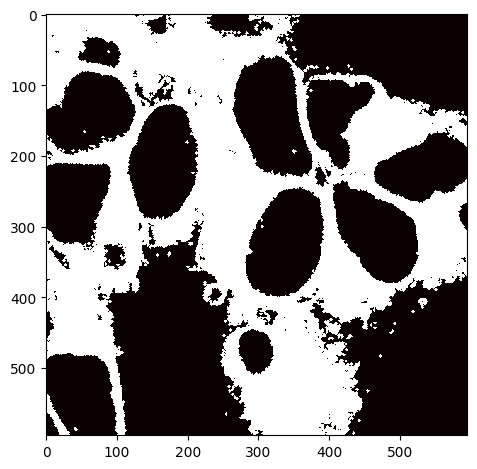

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
031125_lipid_peroxidation_compounds\3K_FIN02_timecourse_01.czi
(36, 2, 596, 596)


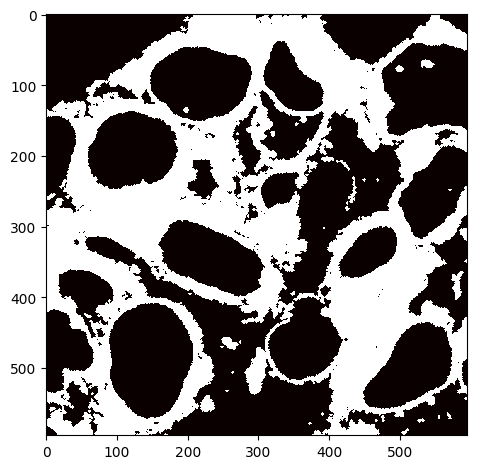

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
031125_lipid_peroxidation_compounds\3K_FIN56_timecourse_01.czi
(36, 2, 596, 596)


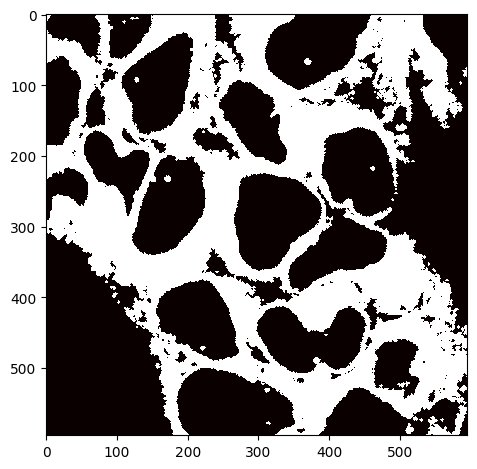

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
031125_lipid_peroxidation_compounds\3K_IKE_timecourse_01.czi
(36, 2, 596, 596)


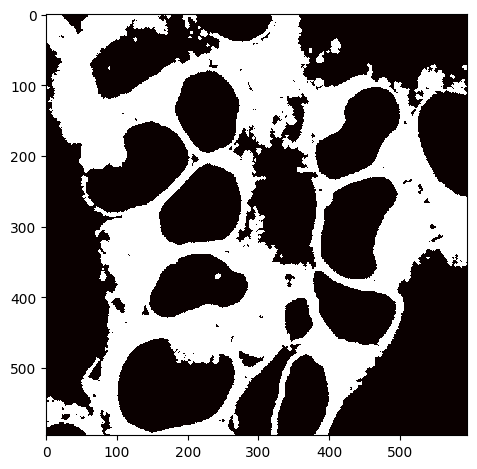

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
031125_lipid_peroxidation_compounds\3K_ML210_timecourse_01.czi
(36, 2, 596, 596)


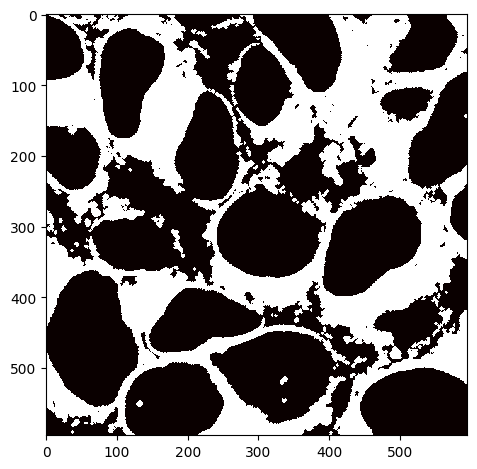

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
031125_lipid_peroxidation_compounds\3K_OA_erastin_timecourse_01.czi
(36, 2, 596, 596)


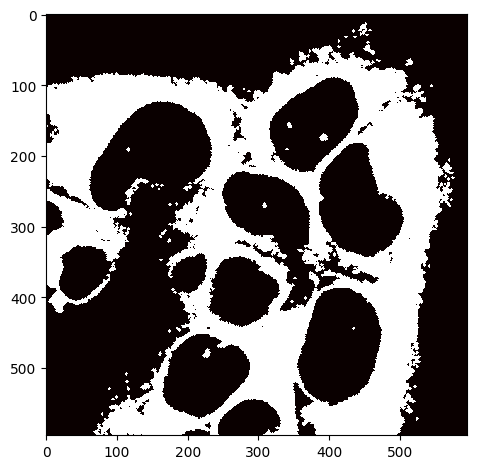

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
031125_lipid_peroxidation_compounds\3K_OA_FIN02_timecourse_01.czi
(36, 2, 596, 596)


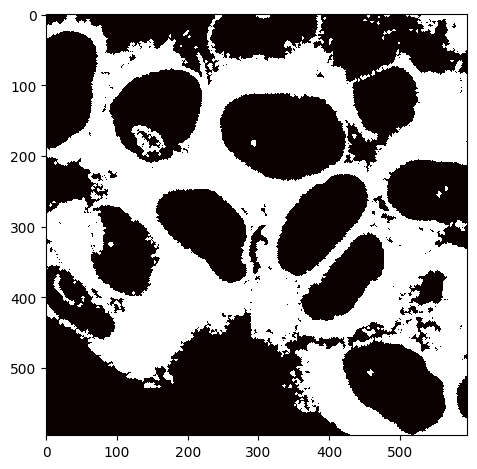

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
031125_lipid_peroxidation_compounds\3K_OA_FIN56_timecourse_01.czi
(36, 2, 596, 596)


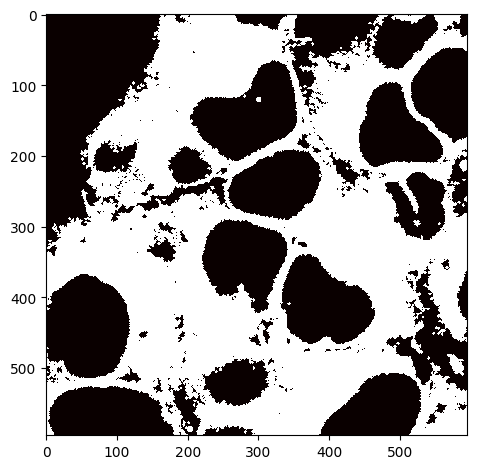

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
031125_lipid_peroxidation_compounds\3K_OA_IKE_timecourse_01.czi
(36, 2, 596, 596)


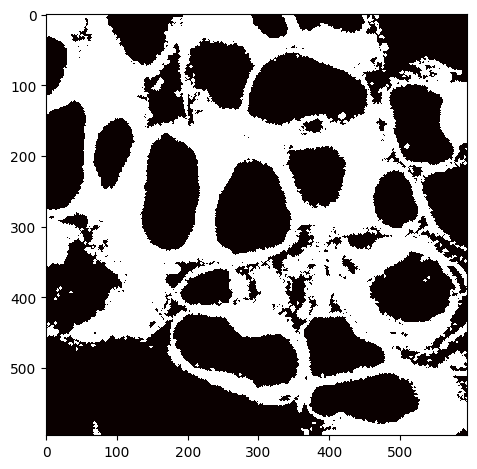

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
031125_lipid_peroxidation_compounds\3K_OA_ML210_timecourse_01.czi
(36, 2, 596, 596)


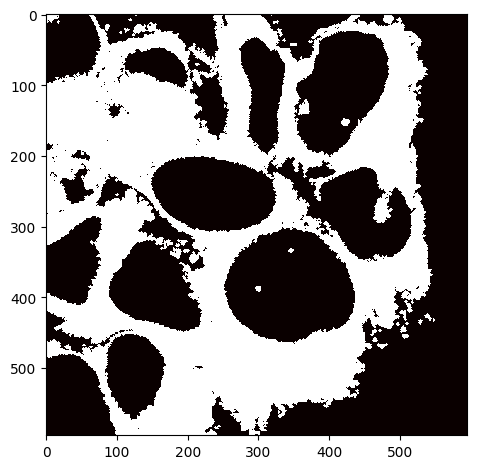

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
031125_lipid_peroxidation_compounds\3K_OA_timecourse_01.czi
(36, 2, 596, 596)


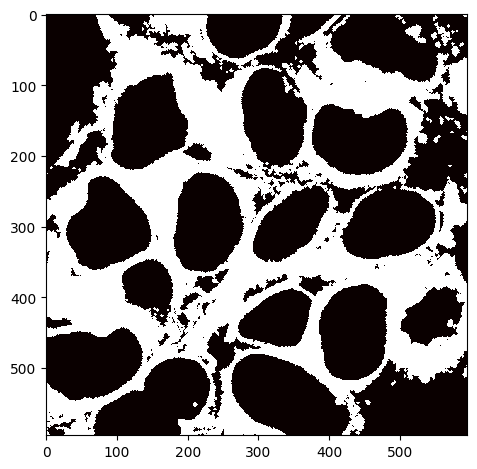

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
031125_lipid_peroxidation_compounds\3K_timecourse_01.czi
(36, 2, 596, 596)


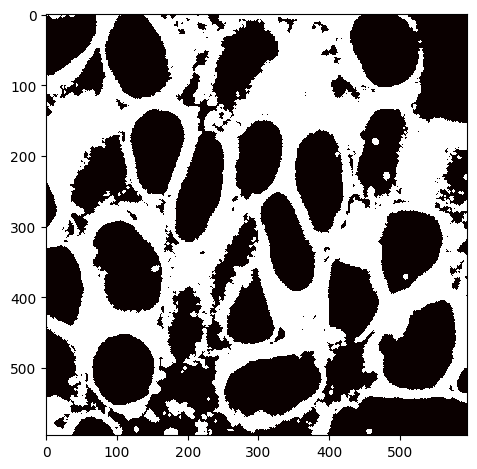

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [12]:
# analyze_main_folder('./',True)
analyze_all_images('031125_lipid_peroxidation_compounds',verbose=True)